In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import json
import pickle
from tqdm import tqdm

from sklearn.metrics import precision_recall_fscore_support
import datetime

import numpy as np
from sklearn.metrics import f1_score

In [2]:
def create_dataset(dataset_type):
    tweet_ids = []
    tweet_labels = []

    with open(f'data/{dataset_type}.data.pro.txt', mode='r') as data_file, \
            open(f'data/{dataset_type}.label.pro.txt', mode='r') as label_file:
        labels = label_file.readlines()
        data = data_file.readlines()

        for index, line in enumerate(tqdm(data, colour="green")):
            ids = [int(i) for i in line.strip().split(',')]
            source_id = ids[0]

            replies = []
            for reply_id in ids[1:]:
                try:
                    with open(f'{dataset_type}-data/{reply_id}.json', 'r') as tweet_json:
                        tweet = json.load(tweet_json)
                        if tweet['in_reply_to_status_id'] == source_id:
                            ts = datetime.datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S +0000 %Y')
                            replies.append((reply_id, ts))
                except:
                    continue
            
            sorted_by_time = sorted(replies, key=lambda tup: tup[1], reverse=True)
            tweet_ids.append([id_ for id_, _ in sorted_by_time] + [source_id])
            
            tweet_labels.append(float(labels[index].strip()))

    return tweet_ids, tweet_labels

train_tweet_ids, train_tweet_labels = create_dataset('train')
dev_tweet_ids, dev_tweet_labels = create_dataset('dev')

print(len(train_tweet_ids), len(train_tweet_labels))
print(len(dev_tweet_ids), len(dev_tweet_labels))

100%|██████████| 534/534 [00:41<00:00, 13.01it/s]

1561 1561
534 534


In [3]:
with open('output/train.tfidf.pkl', 'rb') as handle:
    train_id2tfidf = pickle.load(handle)

with open("output/dev.tfidf.pkl", 'rb') as handle:
    dev_id2tfidf = pickle.load(handle)

In [4]:
import pickle
# import numpy as np

twitter_id = 0

def get_feature_vectors(dataset, train_or_dev):
    feature_vecs = []
    for tweet_ids in tqdm(dataset):
        feature_vec = []
        source_id = tweet_ids[0]

        if train_or_dev == 'train':
            feature_vec.append(torch.Tensor(train_id2tfidf[source_id]))
            for reply_id in tweet_ids[1:]:
                feature_vec.append(torch.Tensor(train_id2tfidf[reply_id]))
        elif train_or_dev == 'dev':
            feature_vec.append(torch.Tensor(dev_id2tfidf[source_id]))
            for reply_id in tweet_ids[1:]:
                feature_vec.append(torch.Tensor(dev_id2tfidf[reply_id]))
        
        feature_vecs.append(feature_vec)

    return feature_vecs

train_feature_vectors = get_feature_vectors(train_tweet_ids, 'train')
dev_feature_vectors = get_feature_vectors(dev_tweet_ids, 'dev')

100%|██████████| 534/534 [00:00<00:00, 4076.37it/s]


In [5]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [6]:
train_set = TweetDataset(train_feature_vectors, train_tweet_labels)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

dev_set = TweetDataset(dev_feature_vectors, dev_tweet_labels)
dev_loader = torch.utils.data.DataLoader(dev_set, batch_size=1)

In [7]:
class AttentionalLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionalLSTMClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = 2
        
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=self.num_layers, dropout=0.5, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.att = nn.Linear(hidden_dim * 2, 1) # attention

    def forward(self, x):        
        x = torch.stack(x)

        outputs, _ = self.lstm(x) # L sequence length, N batch size, H input_size

        # compute attention scores to each RNN hidden state (we use a linear function)
        att_scores = self.att(outputs)

        # rescale the attention scores using a softmax, so they sum to one
        alpha = F.softmax(att_scores, dim=0)

        # compute the "c" vector as a weighted combination of the RNN hidden states
        c = torch.sum(torch.mul(outputs, alpha), dim=0)

        # now couple up the c state to the output
        output = self.fc_out(self.dropout(torch.squeeze(c, 0)))
        
        return output

In [8]:
# batch = next(iter(train_loader))
# clf = AttentionalLSTMClassifier(6000, 256, 1)
# clf(batch[0])

In [9]:
def move_to(obj, device):
  if torch.is_tensor(obj):
    return obj.to(device)
  elif isinstance(obj, dict):
    res = {}
    for k, v in obj.items():
      res[k] = move_to(v, device)
    return res
  elif isinstance(obj, list):
    res = []
    for v in obj:
      res.append(move_to(v, device))
    return res
  else:
    raise TypeError("Invalid type for move_to")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
model = AttentionalLSTMClassifier(input_dim=6000, hidden_dim=512, output_dim=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [11]:
def train(model, criterion, optimizer, train_loader, dev_loader, n_epochs, device):
    train_loss, train_acc, val_loss, val_acc = list(), list(), list(), list()
    best_acc = 0

    for epoch in range(1, n_epochs + 1):
        print(f"\nEpoch {epoch}/{n_epochs}")
        model.train()
        
        epoch_loss = []
        y_true = []
        y_pred = []

        for it, batch in enumerate(train_loader):
            inputs, labels = batch
            
            inputs = move_to(inputs, device)
            label = move_to(labels, device)

            logits = model(inputs)

            loss = criterion(logits, label)

            loss.backward()

            # save loss
            epoch_loss.append(loss.item())
            
            # calculate f1 score
            y_true.append(label.item())
            probs = torch.sigmoid(logits.unsqueeze(-1))
            soft_probs = (probs > 0.5).long()
            y_pred.append(soft_probs.item())

            if it % 32 == 0 and it > 0:
                optimizer.step()
                optimizer.zero_grad()

        train_p, train_r, train_f, _ = precision_recall_fscore_support(y_true, y_pred, pos_label=1, average="binary", zero_division=0)
        train_epoch_loss = sum(epoch_loss) / len(epoch_loss)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_f)
        
        print(f'[TRAIN] Epoch {epoch} | loss {train_epoch_loss:.4f} | f1 {train_f:.4f} | p {train_p:.4f} | r {train_r:.4f}')

        p, r, f, dev_loss = evaluate(model, criterion, dev_loader, device)
        val_loss.append(dev_loss)
        val_acc.append(f)

        print(f'[DEV] Epoch {epoch} | loss {dev_loss:.4f} | f1 {f:.4f} | p {p:.4f} | r {r:.4f}') 
        if f > best_acc:
            print(f"[SAVE] Best dev f1 improved from {best_acc:.4f} to {f:.4f}, saving model...")
            best_acc = f
            torch.save(model.state_dict(), 'models/best_f1.mdl')

    return train_loss, train_acc, val_loss, val_acc

In [12]:
def evaluate(model, criterion, dataloader, device):
    model.eval()

    mean_loss = []
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch

            inputs = move_to(inputs, device)
            label = move_to(labels, device)
            
            logits = model(inputs)
            mean_loss.append(criterion(logits, label).item())

            y_true.append(label.item())
            probs = torch.sigmoid(logits.unsqueeze(-1))
            soft_probs = (probs > 0.5).float()
            y_pred.append(soft_probs.item())

    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, pos_label=1, average="binary", zero_division=0)
    return p, r, f, sum(mean_loss) / len(mean_loss)

In [13]:
num_epoch = 10

train_loss, train_acc, val_loss, val_acc = train(model, criterion, optimizer, train_loader, dev_loader, num_epoch, device)


Epoch 1/10
[TRAIN] Epoch 1 | loss 0.4746 | f1 0.4020 | p 0.4207 | r 0.3849
[DEV] Epoch 1 | loss 0.4781 | f1 0.5926 | p 0.4593 | r 0.8348
[SAVE] Best dev f1 improved from 0.0000 to 0.5926, saving model...

Epoch 2/10
[TRAIN] Epoch 2 | loss 0.2616 | f1 0.7157 | p 0.7249 | r 0.7066
[DEV] Epoch 2 | loss 0.2498 | f1 0.7838 | p 0.8131 | r 0.7565
[SAVE] Best dev f1 improved from 0.5926 to 0.7838, saving model...

Epoch 3/10
[TRAIN] Epoch 3 | loss 0.0799 | f1 0.9291 | p 0.9277 | r 0.9306
[DEV] Epoch 3 | loss 0.2680 | f1 0.8173 | p 0.9140 | r 0.7391
[SAVE] Best dev f1 improved from 0.7838 to 0.8173, saving model...

Epoch 4/10
[TRAIN] Epoch 4 | loss 0.0187 | f1 0.9874 | p 0.9843 | r 0.9905
[DEV] Epoch 4 | loss 0.2927 | f1 0.8393 | p 0.8624 | r 0.8174
[SAVE] Best dev f1 improved from 0.8173 to 0.8393, saving model...

Epoch 5/10
[TRAIN] Epoch 5 | loss 0.0066 | f1 0.9953 | p 0.9968 | r 0.9937
[DEV] Epoch 5 | loss 0.3733 | f1 0.8349 | p 0.8835 | r 0.7913

Epoch 6/10
[TRAIN] Epoch 6 | loss 0.0079 

### Plot

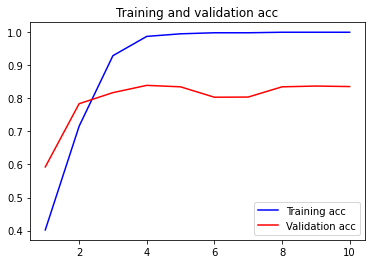

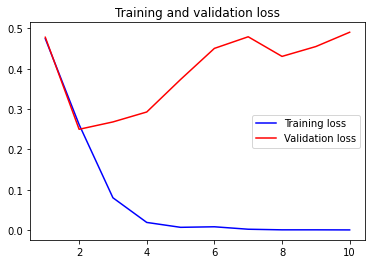

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
predict_model = AttentionalLSTMClassifier(input_dim=6000, hidden_dim=512, output_dim=1).to(device)
predict_model.load_state_dict(torch.load(f'models/best_f1.mdl'))
predict_model.eval() # set to eval mode

# dev_file_path = 'data/dev.csv'
# dev_df = pd.read_csv(dev_file_path)

# dev_dataset = TweetDataset(dev_df, tokenizer=tokenizer)
dev_turing_loader = torch.utils.data.DataLoader(dev_set, batch_size=1)
train_turing_loader = torch.utils.data.DataLoader(train_set, batch_size=1)

y_probs = []
y_labels = []

with torch.no_grad():
    for batch in dev_turing_loader:
        inputs, labels = batch

        inputs = move_to(inputs, device)
        # label = move_to(labels, device)
        
        logits = model(inputs)
        probs = torch.sigmoid(logits.squeeze())
        
        y_probs.append(probs.cpu().item())
        y_labels.append(labels.cpu().item())

In [25]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold
scores = [f1_score(y_labels, to_labels(y_probs, t), pos_label=1, average="binary", zero_division=0) for t in thresholds]

# get best threshold
ix = np.argmax(scores)

# print('Threshold=%.3f, F-Score=%.5f' % (thresholds[500], scores[500]))
print('Best Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

threadhold = thresholds[ix]

Best Threshold=0.007, F-Score=0.84956
